In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics, svm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from logitboost import LogitBoost
# from autogluon.tabular import TabularDataset, TabularPredictor

import imodels
import sys
sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

def predict_stats(y_true, y_pred_prob, verbose = True) :
    '''
    Choose the threshold for probability using Youden's J-statistic (tpr - fpr),
    then prints AUC, accuracy, balanced accuracy, sensitivity, and specificity
    
    input
    ------
    y_true      : true outcome values
    y_pred_prob : predicted probability of being positive (tbi)
    verbose     : Print the statistics or not
    
    output
    ------
    Prints (if verbose = True) and returns the dictionary containing statistics
    (AUC, accuracy, balanced accuracy, sensitivity, specificity)
    '''
    
    from sklearn.metrics import confusion_matrix
    
    fpr, tpr, thresholds = roc_curve(y_tune, y_pred_prob)
    J = tpr - fpr
    thresh = thresholds[np.argmax(J)]  
    y_tune_pred = y_pred_prob > thresh

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_tune_pred)
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_tune, y_pred_prob)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    balacc = (sens + spec) / 2
    
    if verbose :
        print('Confusion Matrix : \n', cm)
        print(f'Prob. threshold : {thresh:.5f}')
        print(f'AUC             : {auc:.3f}')  
        print(f'Accuracy        : {acc:.3f}')
        print(f'Sensitivity     : {sens:.3f}')
        print(f'Specificity     : {spec:.3f}')
        print(f'Balanced Acc.   : {balacc:.3f}')

    return {'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, "Sensitivity" : sens, "Specificity" : spec}

In [3]:
# Cleaning and Preprocessing (only at the first time) 
df = Dataset().clean_data(data_path = data_path)
df = Dataset().preprocess_data(df, **Dataset().get_judgement_calls_dictionary()['preprocess_data'])
    

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.90s/it]
C:\Users\hyunsuk\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
##################
# DATA SELECTION #
##################

simple = True    # 43 Columns or 118 Columns
young = True     # Include Age < 2                  (6432 + 2144 + 2145 samples)
old = True       # Include Age > 2                  (19025 + 6342 + 6432 samples)



df_train, df_tune, df_test = Dataset().get_data(simple=simple, young=young, old=old)
outcome_def = 'outcome'
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


In [36]:
print(X_train.shape)

(25458, 43)


# Fitting models to simple data - we need a pipeline*

## Logistic regression

100%|█████████████████████████████████████████████████████████████████████████████| 3342/3342 [00:07<00:00, 468.99it/s]


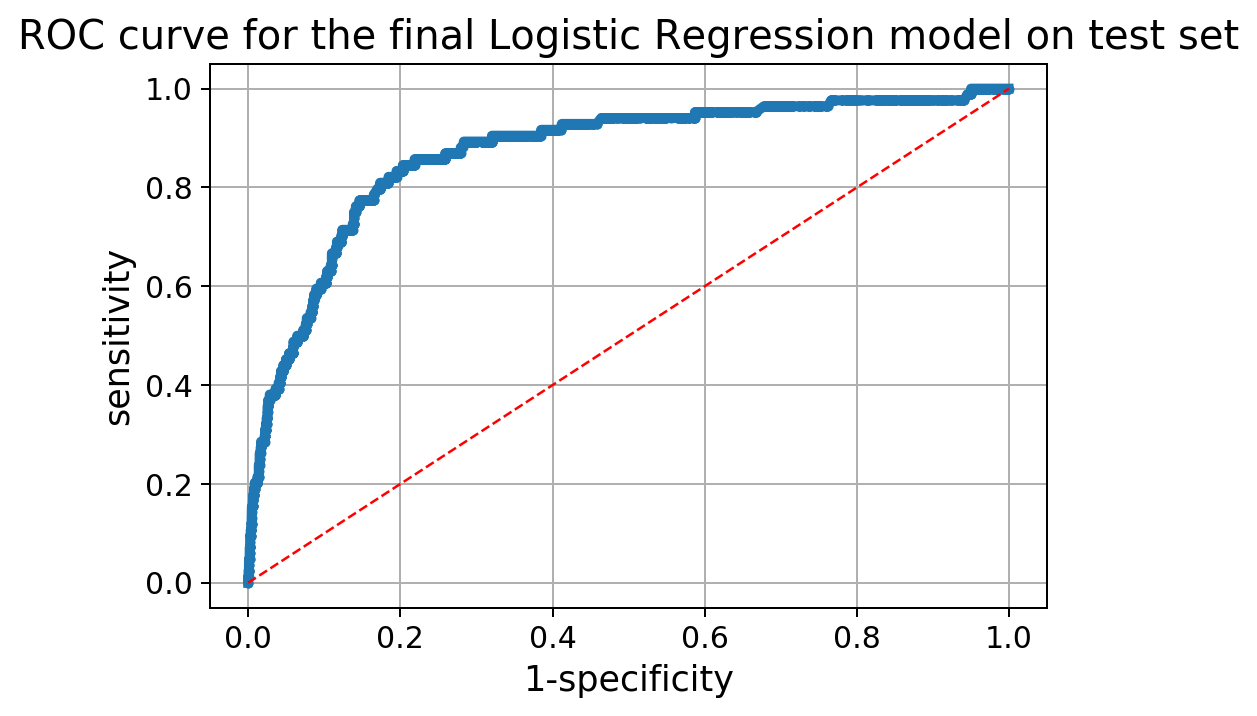

Confusion Matrix : 
 [[6694 1708]
 [  14   70]]
Prob. threshold : 0.00744
AUC             : 0.870
Accuracy        : 0.797
Sensitivity     : 0.797
Specificity     : 0.833
Balanced Acc.   : 0.815


{'AUC': 0.8697107264710218,
 'Accuracy': 0.7970775394767853,
 'Balanced Accuracy': 0.8150242005871617,
 'Sensitivity': 0.7967150678409902,
 'Specificity': 0.8333333333333334}

In [37]:

lamb_vec = [0.001, 0.01, 0.1, 1, 2, 5, 10]

# Now fitting logistic regression
logreg_model = LogisticRegression(solver='liblinear', random_state = 0).fit(X_train, y_train)
roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1])  # Train AUC : 0.9513

# Tuning logistic regression
roc_tune = []
acc_tune = []

for lamb in lamb_vec :
    logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(X_train, y_train)
    roc_tune.append(roc_auc_score(y_tune, logreg_model.predict_proba(X_tune)[:, 1]))
    acc_tune.append(logreg_model.score(X_tune, y_tune))
    
np.around(roc_tune, 5) # [0.90894, 0.91271, 0.91609, 0.91635, 0.91627, 0.91622, 0.91627]
np.around(acc_tune, 5) # [0.98376, 0.98629, 0.9871 , 0.98687, 0.98687, 0.98687, 0.98687]

best_lamb = lamb_vec[np.argmax(np.array(roc_tune))]

'''
# Using 1 as final regularization
logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(pd.concat([X_train, X_tune], axis = 0), 
                                                                                      np.hstack((y_train, y_tune)))
print(roc_auc_score(y_simp_test, logreg_model.predict_proba(X_simp_test)[:, 1]))  # 0.94451
print(logreg_model.score(X_simp_test, y_simp_test))  # 0.98583
'''

# Plot for the best result of tuning
logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = best_lamb).fit(X_train, y_train)
validation.all_stats_curve(y_tune, logreg_model.predict_proba(X_tune)[:, 1], plot = True)
plt.title('ROC curve for the final Logistic Regression model on test set')
plt.show()

#print(roc_auc_score(y_tune, logreg_model.predict_proba(X_tune)[:, 1]))  # 0.86971
#print(logreg_model.score(X_tune, y_tune))   # 0.98998
#print(classification_report(y_tune, logreg_model.predict(X_tune)))  
predict_stats(y_tune, logreg_model.predict_proba(X_tune)[:, 1])

In [38]:
best_lamb

1

## Boosted (LogitBoost & AdaBoost)

Confusion Matrix : 
 [[7391 1011]
 [  43   41]]
Prob. threshold : 0.00000
AUC             : 0.701
Accuracy        : 0.876
Sensitivity     : 0.880
Specificity     : 0.488
Balanced Acc.   : 0.684
Confusion Matrix : 
 [[6764 1638]
 [  15   69]]
Prob. threshold : 0.48733
AUC             : 0.865
Accuracy        : 0.805
Sensitivity     : 0.805
Specificity     : 0.821
Balanced Acc.   : 0.813


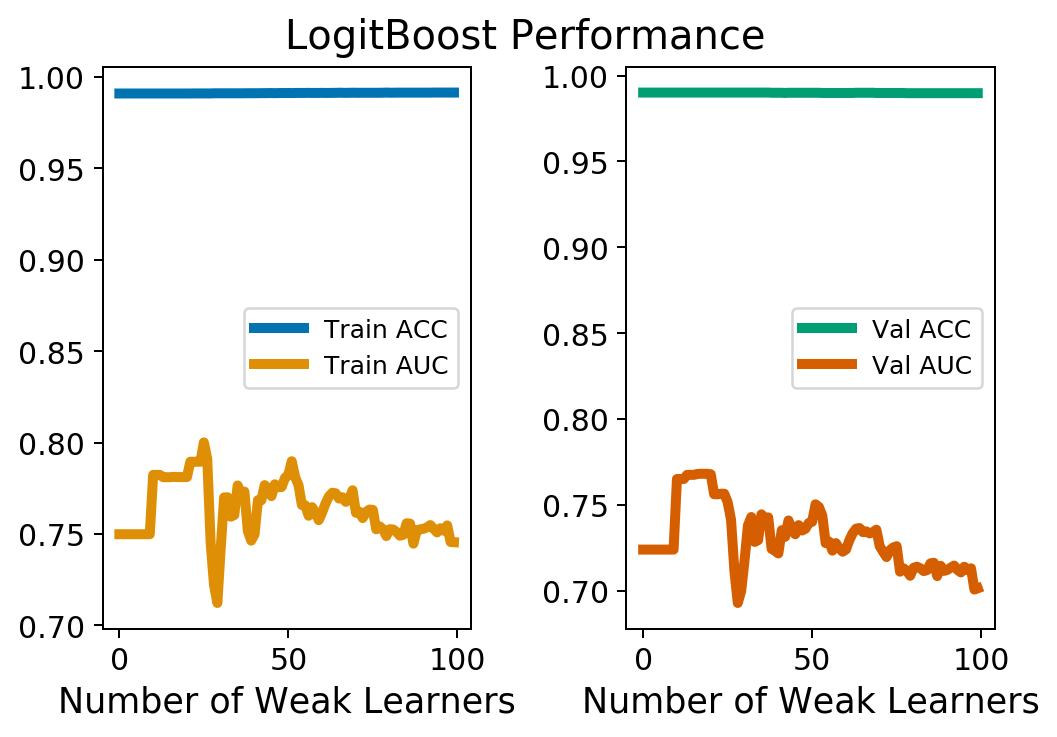

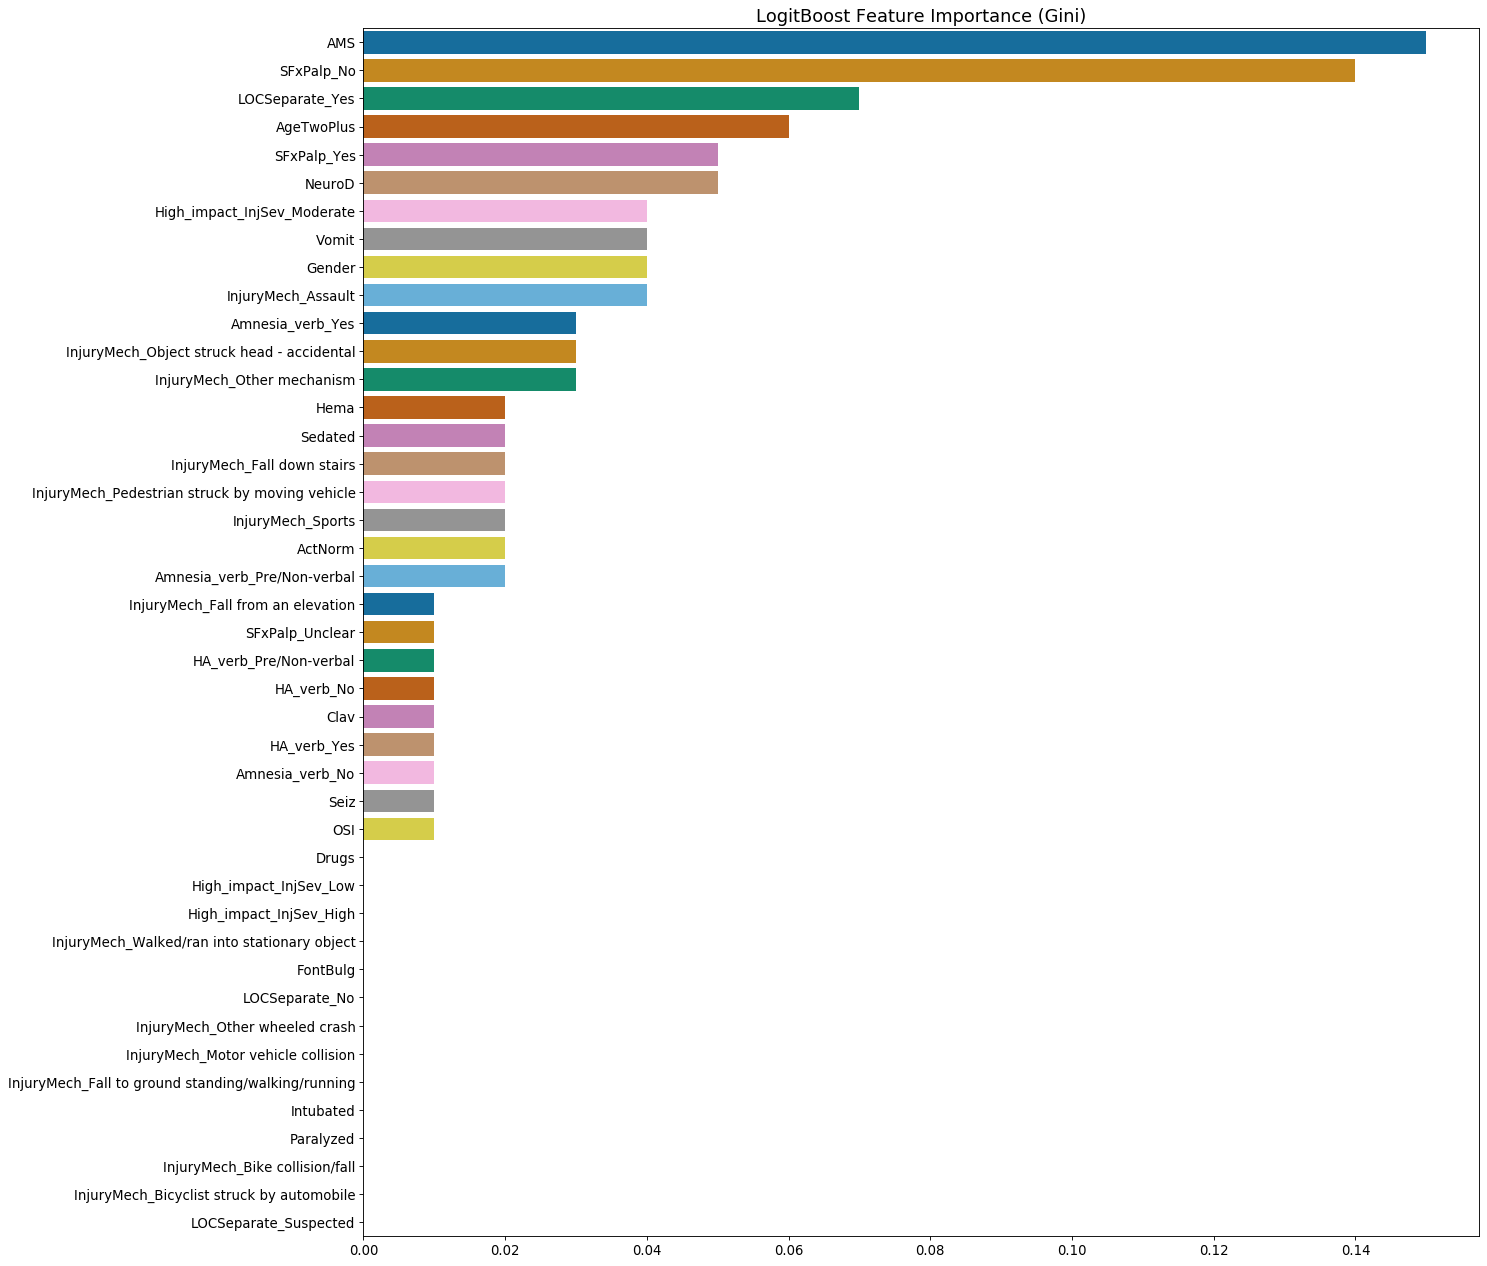

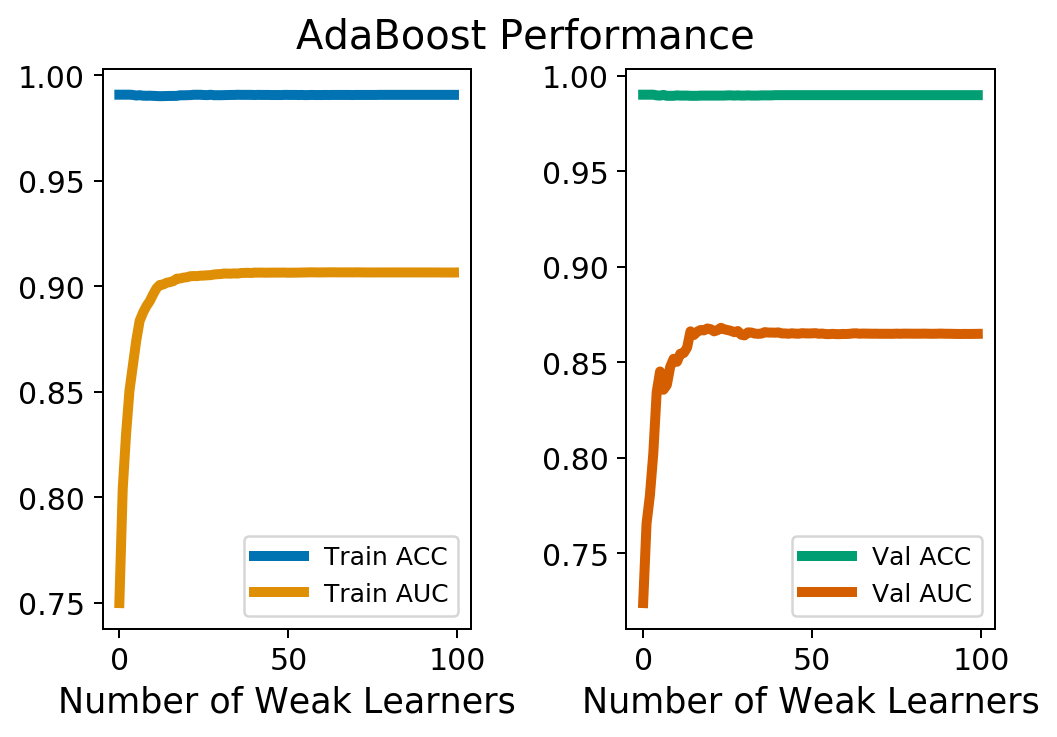

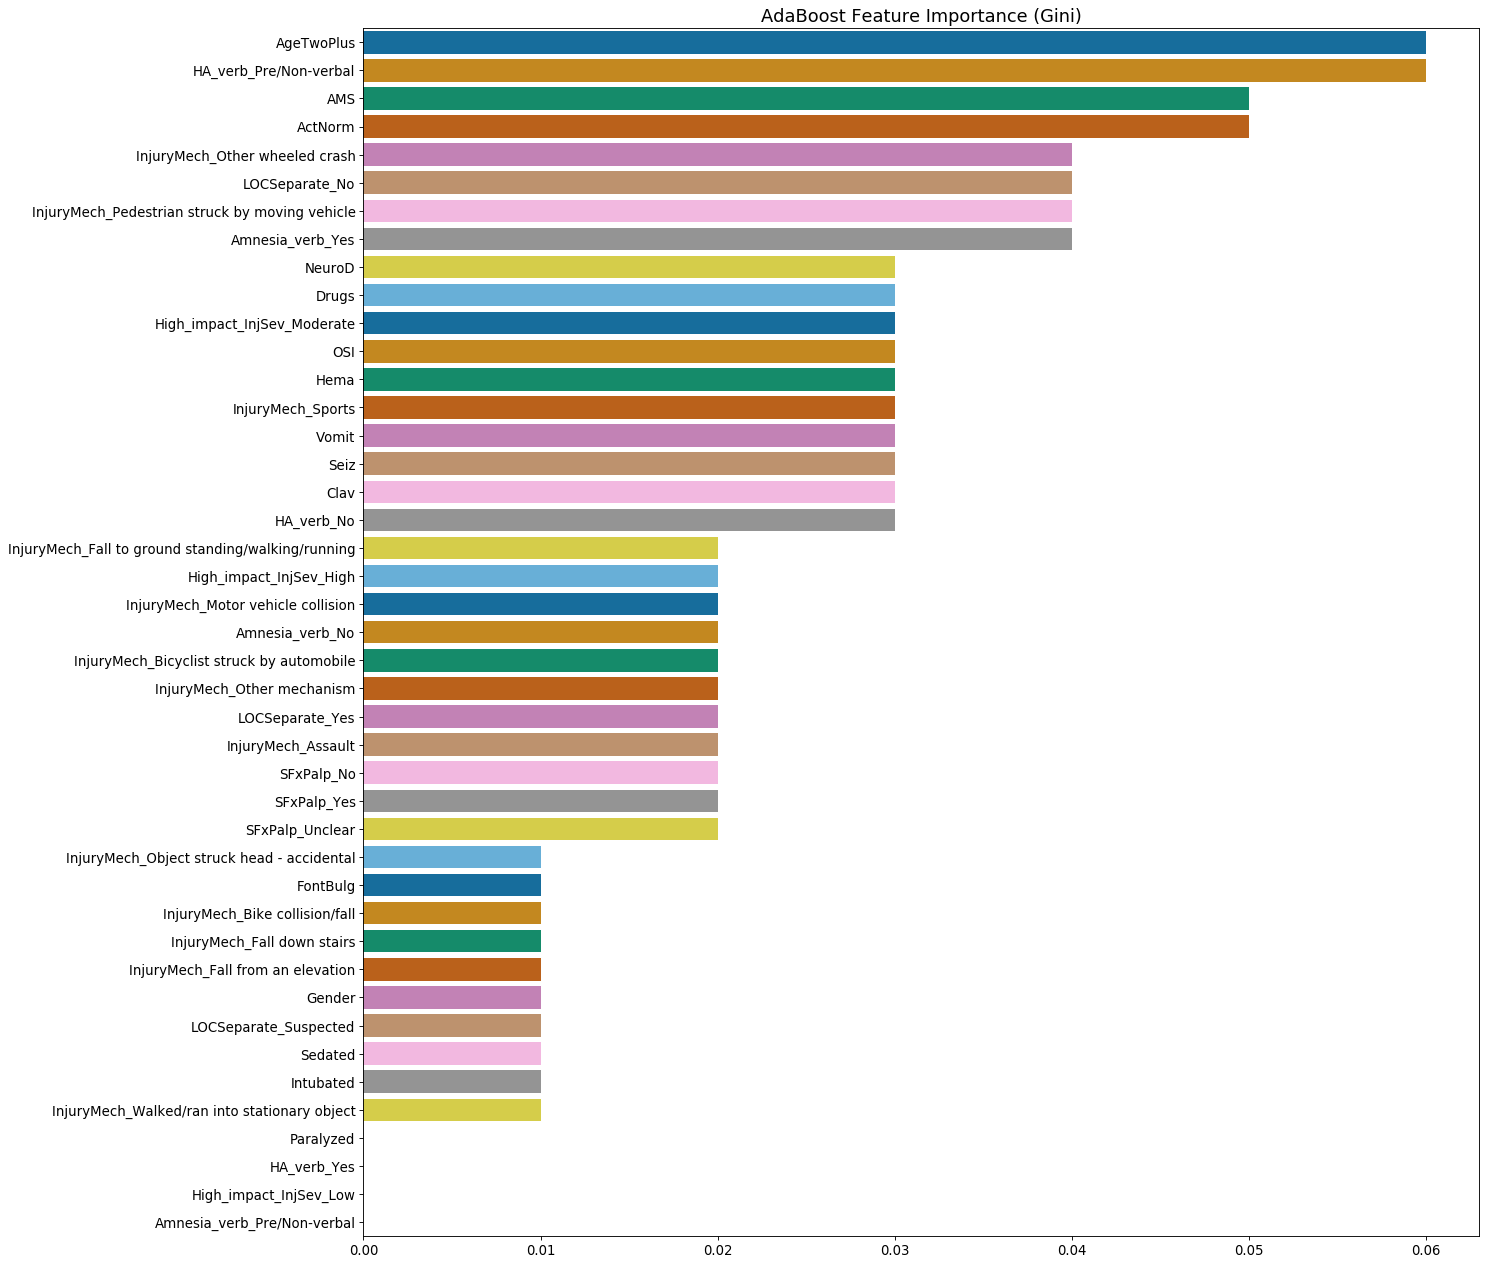

In [39]:
import warnings

def fit_eval_boosted(model, X_train, y_train, X_val, y_val, title_str):
    # Fit model
    model.fit(X_train, y_train)
    
    # Find accuracies on train/val sets
    # This takes ~2 minutes to run
    auc_train = []
    acc_train = []
    auc_val = []
    acc_val = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_pred = list(model.staged_predict_proba(X_train))
        val_pred = list(model.staged_predict_proba(X_val))
        for tp in train_pred:
            auc_train.append(roc_auc_score(y_train, tp[:, 1]))
            acc_train.append((y_train == tp.argmax(axis=1)).mean())
            
        for vp in val_pred:
            auc_val.append(roc_auc_score(y_val, vp[:, 1]))
            acc_val.append((y_val == vp.argmax(axis=1)).mean())

    # Print out the stats
    predict_stats(y_val, vp[:, 1], verbose = True)
            
    # Plot ACC/AUC as function of number of weak learners
    plt.figure()
    plt.suptitle(title_str + " Performance", y=1.02)

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label="Train ACC", color=color_list[0])
    plt.plot(auc_train, label="Train AUC", color=color_list[1])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_val, label="Val ACC", color=color_list[2])
    plt.plot(auc_val, label="Val AUC", color=color_list[3])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.tight_layout()
    
    # Plot Feature Importances
    barplot(pd.Series(dict(zip(X_train.columns, 
                           model.feature_importances_))).sort_values(ascending=False),
        False, title_str + " Feature Importance (Gini)"
       )
    
    return (model, {"acc_train" : acc_train, "auc_train" : auc_train, "acc_val" : acc_val, "auc_val" : auc_val})

# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
lboost = LogitBoost(n_estimators=100, random_state=0)
lboost, lboost_perf = fit_eval_boosted(lboost, X_train, y_train, X_tune, y_tune, "LogitBoost")

# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
aboost = AdaBoostClassifier(n_estimators=100, random_state=0)
aboost, aboost_perf = fit_eval_boosted(aboost, X_train, y_train, X_tune, y_tune, "AdaBoost")

## Decision Tree

In [40]:
# decision tree traversing func
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED 
                    else "Undefined!" for i in tree_.feature]
    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)    
    samples_count = [p[-1][1] for p in paths]
    sorted_samples = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(sorted_samples)]
    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
            rule += '\n'
            
        rule += " then\n"
        if class_names is None:
            rule += "response: " + str(np.round(path[-1][0][0][0], 3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"\t class: {class_names[l]} (prob: {np.round(100 * classes[l] / np.sum(classes), 2)}%)"
        rule += f" | {path[-1][1]:,} samples\n\n"
        rules += [rule]
        
    return rules

# Tuning the depth of the tree
roc_tune = []
acc_tune = []
for depth in range(1, 6):
    
    dt = DecisionTreeClassifier(max_depth=depth, class_weight={0: 1, 1:100})
    dt.fit(X_train, y_train)
    roc_tune.append(roc_auc_score(y_tune, dt.predict_proba(X_tune)[:, 1]))
    acc_tune.append(dt.score(X_tune, y_tune))
    # Print out the stats
    predict_stats(y_tune, dt.predict_proba(X_tune)[:, 1], verbose = True)

print(f'ROC Scores: {np.around(roc_tune, 2)}\n')
print(f'ACC Scores: {np.around(acc_tune, 2)}\n')


# NOT USING TEST SET FOR THE MOMENT
'''
# use the depth 5
depth = 5
dt = DecisionTreeClassifier(max_depth=depth, class_weight={0: 1, 1:100})
dt.fit(X_train, y_train)
print(f'ROC of depth {depth}: {roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])}')
print(f'ACC of depth {depth}: {dt.score(X_test, y_test)}')
validation.all_stats_curve(y_test, dt.predict_proba(X_test)[:, 1], plot=True)
plt.title('ROC Curve of final Decision Tree on Test Set')
plt.show()
'''

# important features
print('Feature Importances:\n')
for col, val in sorted(zip(X_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')

# plotting decision tree
fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names = X_train.columns, class_names = ['No ciTBI', 'ciTBI'], filled=True)

# plotting probabilities for the different possibilities
print('\n')
rules = get_rules(dt, feature_names, ['No ciTBI', 'ciTBI'])
for rule in rules:
    print(rule)

Confusion Matrix : 
 [[8402    0]
 [  84    0]]
Prob. threshold : 0.82097
AUC             : 0.724
Accuracy        : 0.990
Sensitivity     : 1.000
Specificity     : 0.000
Balanced Acc.   : 0.500
Confusion Matrix : 
 [[7364 1038]
 [  36   48]]
Prob. threshold : 0.54117
AUC             : 0.771
Accuracy        : 0.873
Sensitivity     : 0.876
Specificity     : 0.571
Balanced Acc.   : 0.724
Confusion Matrix : 
 [[6302 2100]
 [  26   58]]
Prob. threshold : 0.40816
AUC             : 0.773
Accuracy        : 0.749
Sensitivity     : 0.750
Specificity     : 0.690
Balanced Acc.   : 0.720
Confusion Matrix : 
 [[7013 1389]
 [  32   52]]
Prob. threshold : 0.56457
AUC             : 0.771
Accuracy        : 0.833
Sensitivity     : 0.835
Specificity     : 0.619
Balanced Acc.   : 0.727
Confusion Matrix : 
 [[6615 1787]
 [  23   61]]
Prob. threshold : 0.39705
AUC             : 0.783
Accuracy        : 0.787
Sensitivity     : 0.787
Specificity     : 0.726
Balanced Acc.   : 0.757
ROC Scores: [0.72 0.77 0.77 0.

NameError: name 'feature_names' is not defined

## SVM

In [19]:
roc_tune = []
acc_tune = []
for c in [2**(-3), 2**(-2), 2**(-1), 1, 2**(1), 2**(2), 2**(3), 2**(-1.75), 2**(-1.5), 2**(-1.25), 2**(-0.75), 2**(-0.5)]:
    svm_v = svm.SVC(C=c, probability=True).fit(X_train, y_train)
    roc_tune.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
    acc_tune.append(svm_v.score(X_tune, y_tune))

print("Validation AUC:", np.around(roc_tune, 5))
print("Validation ACC:", np.around(acc_tune, 5))

# choosing c=1
svm_final = svm.SVC(C=1, probability=True).fit(pd.concat([X_train], axis=0), np.hstack((y_train)))

# Print out the stats
predict_stats(y_tune, svm_final.predict_proba(X_tune)[:, 1], verbose = True)
#print("Test AUC:", roc_auc_score(y_test, svm_final.predict_proba(X_test)[:, 1])) 
#print("Test ACC:", svm_final.score(X_test, y_test))

# NOT USING TEST SET FOR THE MOMENT
'''
# Plot the result for the test set
validation.all_stats_curve(y_test, svm_final.predict_proba(X_test)[:, 1], plot = True)
plt.title('ROC curve for the final SVM model on test set')
plt.show()
'''

KeyboardInterrupt: 

In [41]:
svm_final = svm.SVC(C=1, probability=True).fit(pd.concat([X_train], axis=0), np.hstack((y_train)))

# Print out the stats
predict_stats(y_tune, svm_final.predict_proba(X_tune)[:, 1], verbose = True)

Confusion Matrix : 
 [[7199 1203]
 [  50   34]]
Prob. threshold : 0.01397
AUC             : 0.644
Accuracy        : 0.852
Sensitivity     : 0.857
Specificity     : 0.405
Balanced Acc.   : 0.631


{'AUC': 0.6440756735924553,
 'Accuracy': 0.8523450388875795,
 'Balanced Accuracy': 0.6307908547851419,
 'Sensitivity': 0.8568198048083789,
 'Specificity': 0.40476190476190477}

## Bayesian Rule List   - I just let simp_ exist

In [78]:
def simp_predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_simp_train, X_simp_tune],
                            [y_simp_train, y_simp_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BigDataRuleListClassifier(listlengthprior=2, max_iter=10000, class1label=1, verbose=False)
brl.fit(X_simp_train, y_simp_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

training bayesian_rule_list...


AttributeError: module 'imodels' has no attribute 'BigDataRuleListClassifier'

In [47]:
print(brl)

(Untrained RuleListClassifier)


## Rulefit

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1482.71it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

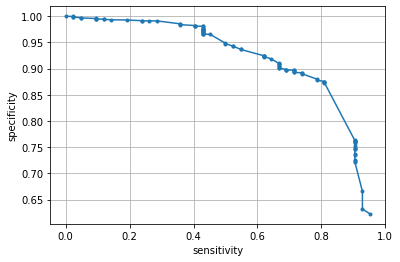

In [15]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [20]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
10,AbdTrauma_no,-0.01
11,AbdTrauma_or_SeatBeltSign_no,-0.02
12,AbdTrauma_or_SeatBeltSign_yes,0.00
29,GCSScore,-0.01
55,VomitWretch_no,-0.00
59,DecrBreathSound_yes <= 0.5 and AbdDistention_yes <= 0.5,-0.01
60,AbdDistention_yes <= 0.5 and AbdTenderDegree_Severe <= 0.5,-0.07
58,GCSScore > 9.5 and AbdTenderDegree_Severe <= 0.5,-0.01
61,VomitWretch_no > 0.5,-0.00


## Greedy (CART) Rule List

/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1109.18it/s]

mean 0.016 (7226 pts)
if AbdDistention >= 1.0 then 0.175 (166 pts)
mean 0.012 (7060 pts)
if feat 8 >= 1.0 then 0.121 (223 pts)
mean 0.009 (6837 pts)
if feat 50 >= 1.0 then 0.044 (615 pts)
mean 0.005 (6222 pts)
if feat 46 >= 1.0 then 0.029 (307 pts)
mean 0.004 (5915 pts)
if feat 6 >= 1.0 then 0.012 (805 pts)
mean 0.003 (5110 pts)
if feat 43 >= 3.0 then 0.02 (101 pts)
mean 0.002 (5009 pts)
if feat 18 >= 17.0 then 0.009 (459 pts)
mean 0.002 (4550 pts)
if feat 33 >= 1.0 then 0.024 (42 pts)
mean 0.001 (4508 pts)
if feat 35 >= 1.0 then 0.007 (302 pts)



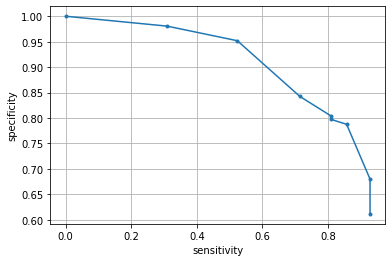

In [24]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

## Random Forest

Confusion Matrix : 
 [[7343 1059]
 [  30   54]]
Prob. threshold : 0.00583
AUC             : 0.776
Accuracy        : 0.872
Sensitivity     : 0.874
Specificity     : 0.643
Balanced Acc.   : 0.758


100%|███████████████████████████████████████████████████████████████████████████████| 335/335 [00:00<00:00, 528.69it/s]


ValueError: not enough values to unpack (expected 3, got 2)

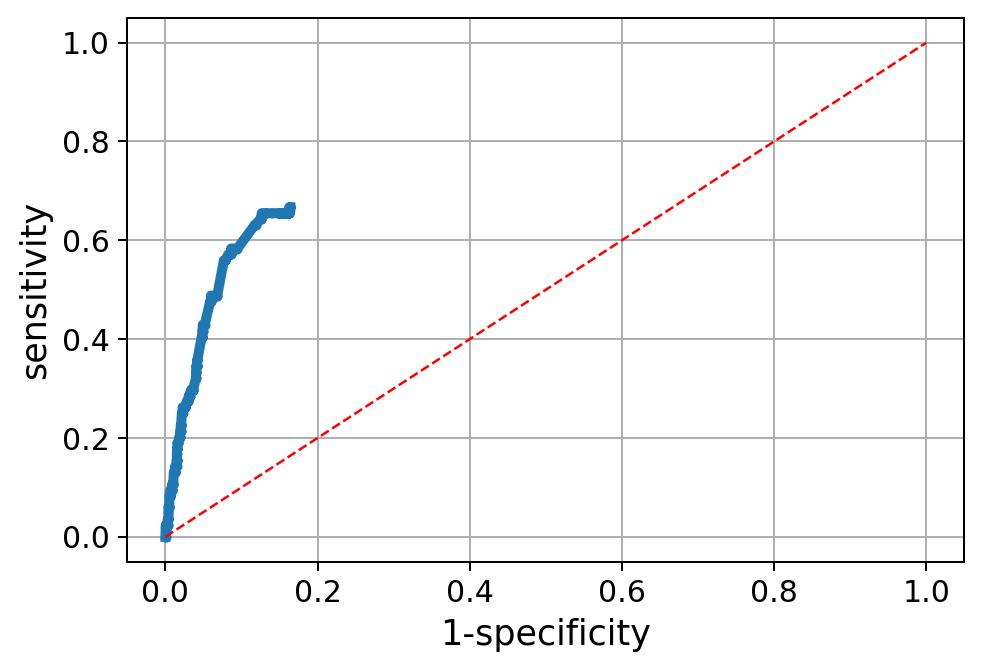

In [42]:
# # specify a decision tree with a maximum depth
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Print out the stats
predict_stats(y_tune, rf.predict_proba(X_tune)[:, 1], verbose = True)

sens, spec, threshes = predict_and_save(rf, model_name='rf')
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])
imps = rf.feature_importances_.round(3)
args = np.argsort(imps)
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
     print(feat, imp)

## Autogluon - autoML stuff, can't download it for some reason...

In [11]:
train_data = X_train
train_data['outcome'] = y_train
predictor = TabularPredictor(label='outcome').fit(train_data, presets='interpretable', time_limit=8, verbosity=2)

,InjuryMech_Assault,InjuryMech_Bicyclist struck by automobile,InjuryMech_Bike collision/fall,InjuryMech_Fall down stairs,InjuryMech_Fall from an elevation,InjuryMech_Fall to ground standing/walking/running,InjuryMech_Motor vehicle collision,InjuryMech_Object struck head - accidental,InjuryMech_Other mechanism,InjuryMech_Other wheeled crash,...,SFxPalp_Yes,FontBulg,Hema,Clav,NeuroD,OSI,Drugs,AgeTwoPlus,Gender,outcome
14091,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,2,0,0
20231,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
15798,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0
223,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
6635,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,0


In [ ]:
predictor.leaderboard(silent=True)

In [ ]:
predictor.interpretable_models_summary()

In [ ]:
predictor.print_interpretable_rules()

# Analyze Results

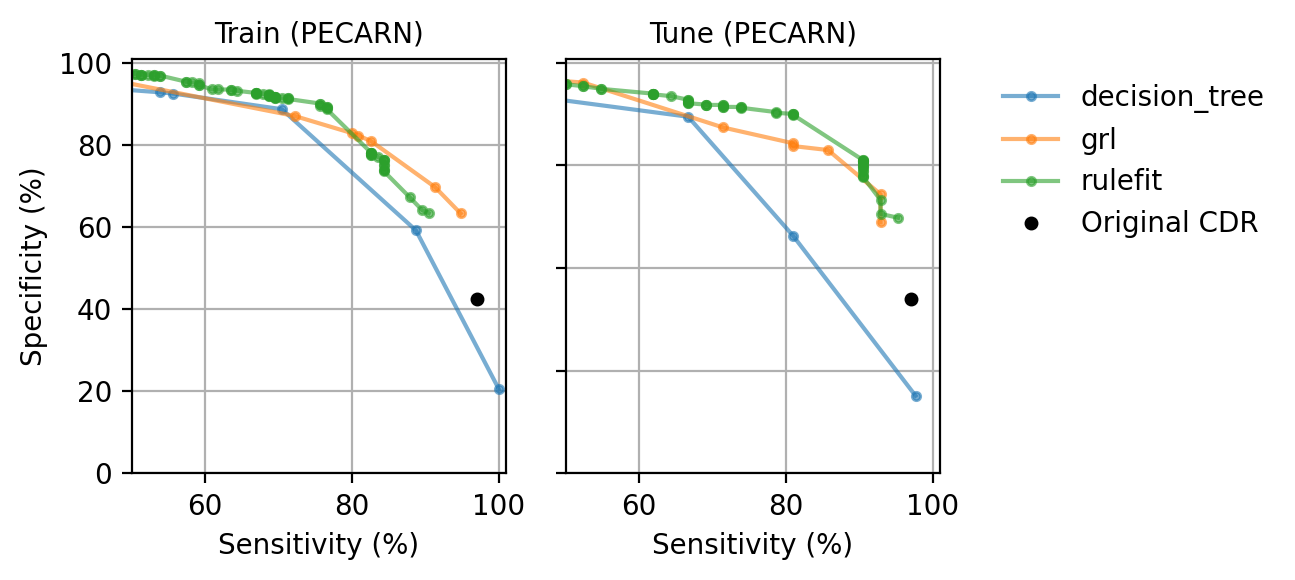

"x\nplt.figure(dpi=200, figsize=(C * 6, R * 6))\nfor i, suffix in enumerate(suffixes):\n    plt.subplot(R, C, i + 1)\n    plot_metrics(suffix, title=titles[i])\n    plt.xlim((80, 101))\n    plt.ylim((25, 70))\nplt.subplot(R, C, 1)    \nplt.legend()\nplt.tight_layout()\nviz.savefig('metrics_3_splits_zoom')\nplt.show()\nplt.legend(bbox_to_anchor=(1.05, 1.05))\n"

In [31]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('figs/metrics_3_splits')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1591.61it/s]


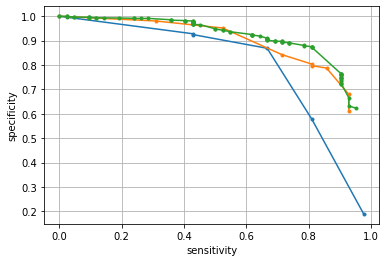

In [37]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

In [38]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.90
spec,0.20,0.63,0.63
ppv,0.02,0.04,0.04
npv,1.00,1.00,1.00
lr+,1.26,2.58,2.47
lr-,0.00,0.08,0.15
brier_score,0.61,0.01,0.08
f1,0.04,0.08,0.07


In [39]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.98,0.93,0.95
spec,0.19,0.68,0.62
ppv,0.02,0.05,0.04
npv,1.00,1.00,1.00
lr+,1.20,2.90,2.52
lr-,0.13,0.11,0.08
brier_score,0.62,0.02,0.08
f1,0.04,0.09,0.08
